In [1]:
import numpy as np

In [2]:
import torchvision

In [3]:
from torchvision import transforms

In [29]:
from torch.utils.data import DataLoader, SubsetRandomSampler

# 定义数据变换
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # 归一化到[-1, 1]
])

# 加载数据集
train_dataset = torchvision.datasets.CIFAR10(
    root=r'nn_hw1',
    train=True,
    transform=transform,
    download=True
)
test_dataset = torchvision.datasets.CIFAR10(
    root=r'nn_hw1',
    train=False,
    transform=transform,
    download=True
)

# 划分训练集和验证集
indices = np.arange(len(train_dataset))
np.random.shuffle(indices)
split = int(0.9 * len(train_dataset))
train_indices, val_indices = indices[:split], indices[split:]

# 创建DataLoader
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=SubsetRandomSampler(train_indices))
val_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=SubsetRandomSampler(val_indices))
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [30]:
class ThreeLayerNN:
    def __init__(self, input_size, hidden_sizes, output_size, activations):
        self.params = {
            'W1': np.random.randn(input_size, hidden_sizes[0]) * np.sqrt(2. / input_size),
            'b1': np.zeros(hidden_sizes[0]),
            'W2': np.random.randn(hidden_sizes[0], hidden_sizes[1]) * np.sqrt(2. / hidden_sizes[0]),
            'b2': np.zeros(hidden_sizes[1]),
            'W3': np.random.randn(hidden_sizes[1], output_size) * np.sqrt(2. / hidden_sizes[1]),
            'b3': np.zeros(output_size)
        }
        self.activations = activations

    def forward(self, X):
        self.cache = {}
        # Layer 1
        Z1 = X.dot(self.params['W1']) + self.params['b1']
        A1 = self._activate(Z1, self.activations[0])
        self.cache['Z1'], self.cache['A1'] = Z1, A1
        # Layer 2
        Z2 = A1.dot(self.params['W2']) + self.params['b2']
        A2 = self._activate(Z2, self.activations[1])
        self.cache['Z2'], self.cache['A2'] = Z2, A2
        # Output layer
        Z3 = A2.dot(self.params['W3']) + self.params['b3']
        self.cache['Z3'] = Z3
        return Z3

    def _activate(self, Z, activation):
        if activation == 'relu':
            return np.maximum(0, Z)
        elif activation == 'sigmoid':
            return 1 / (1 + np.exp(-Z))
        elif activation == 'tanh':
            return np.tanh(Z)
        else:
            raise ValueError("Unsupported activation")

    def backward(self, X, y, reg_lambda):
        m = X.shape[0]
        grads = {}
        # 获取缓存
        Z1, A1 = self.cache['Z1'], self.cache['A1']
        Z2, A2 = self.cache['Z2'], self.cache['A2']
        Z3 = self.cache['Z3']
        W3 = self.params['W3']

        # 计算softmax梯度
        probs = np.exp(Z3 - np.max(Z3, axis=1, keepdims=True))
        probs /= np.sum(probs, axis=1, keepdims=True)
        one_hot = np.eye(10)[y]
        dZ3 = (probs - one_hot) / m

        # 第三层梯度
        grads['W3'] = A2.T.dot(dZ3) + reg_lambda * self.params['W3']
        grads['b3'] = np.sum(dZ3, axis=0)

        # 第二层梯度
        dA2 = dZ3.dot(W3.T)
        dZ2 = dA2 * self._activate_deriv(Z2, self.activations[1])
        grads['W2'] = A1.T.dot(dZ2) + reg_lambda * self.params['W2']
        grads['b2'] = np.sum(dZ2, axis=0)

        # 第一层梯度
        dA1 = dZ2.dot(self.params['W2'].T)
        dZ1 = dA1 * self._activate_deriv(Z1, self.activations[0])
        grads['W1'] = X.T.dot(dZ1) + reg_lambda * self.params['W1']
        grads['b1'] = np.sum(dZ1, axis=0)

        return grads

    def _activate_deriv(self, Z, activation):
        if activation == 'relu':
            return (Z > 0).astype(float)
        elif activation == 'sigmoid':
            s = 1 / (1 + np.exp(-Z))
            return s * (1 - s)
        elif activation == 'tanh':
            return 1 - np.tanh(Z)**2
        else:
            raise ValueError("Unsupported activation")

In [38]:
def train(model, train_loader, val_loader, learning_rate, reg_lambda, epochs, lr_decay=0.1, decay_every=20):
    best_val_acc = 0
    train_losses, val_losses, val_accs = [], [], []

    for epoch in range(epochs):
        # 学习率衰减
        if epoch > 0 and epoch % decay_every == 0:
            learning_rate *= lr_decay

        # 训练
        # model.train()
        for X_batch, y_batch in train_loader:
            X = X_batch.numpy().reshape(-1, 3*32*32)
            y = y_batch.numpy()

            # 前向传播
            logits = model.forward(X)
            loss = cross_entropy(logits, y) + 0.5 * reg_lambda * (np.sum(model.params['W1']**2) + np.sum(model.params['W2']**2) + np.sum(model.params['W3']**2))

            # 反向传播
            grads = model.backward(X, y, reg_lambda)

            # 更新参数
            for param in model.params:
                model.params[param] -= learning_rate * grads[param]

        # 验证
        val_acc, val_loss = evaluate(model, val_loader)
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            np.savez('best_model.npz', **model.params)

        # 记录指标
        train_losses.append(loss)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f'Epoch {epoch+1}: Train Loss={loss:.4f}, Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}')

    return train_losses, val_losses, val_accs

def cross_entropy(logits, y):
    m = y.shape[0]
    log_probs = logits - np.log(np.sum(np.exp(logits), axis=1, keepdims=True))
    return -np.sum(log_probs[np.arange(m), y]) / m

def evaluate(model, data_loader):
    correct = 0
    total = 0
    total_loss = 0
    # model.eval()
    for X_batch, y_batch in data_loader:
        X = X_batch.numpy().reshape(-1, 3*32*32)
        y = y_batch.numpy()
        logits = model.forward(X)
        preds = np.argmax(logits, axis=1)
        correct += np.sum(preds == y)
        total += y.shape[0]
        total_loss += cross_entropy(logits, y) * y.shape[0]
    return correct / total, total_loss / total

In [54]:
def evaluate(model, data_loader):
    correct = 0
    total = 0
    total_loss = 0
    # model.eval()
    for X_batch, y_batch in data_loader:
        X = X_batch.numpy().reshape(-1, 3*32*32)
        y = y_batch.numpy()
        logits = model.forward(X)
        preds = np.argmax(logits, axis=1)
        correct += np.sum(preds == y)
        total += y.shape[0]
        total_loss += cross_entropy(logits, y) * y.shape[0]
    return correct / total, total_loss / total

In [67]:
# hidden_sizes_list = [[512, 256], [1024, 512]]
# learning_rates = [1e-3, 1e-4]
# reg_lambdas = [0.001, 0.0001]
hidden_sizes_list = [[512, 256]]
learning_rates = [1e-2]
reg_lambdas=[1e-3]

best_acc = 0
best_params = {}

for hs in hidden_sizes_list:
    for lr in learning_rates:
        for reg in reg_lambdas:
            model = ThreeLayerNN(3072, hs, 10, ['relu', 'relu'])
            print(f'Training with hs={hs}, lr={lr}, reg={reg}')
            train_loss, val_loss, val_acc = train(model, train_loader, val_loader, lr, reg, 50)
            if max(val_acc) > best_acc:
                best_acc = max(val_acc)
                best_params = {'hs': hs, 'lr': lr, 'reg': reg}

print(f'Best params: {best_params} with acc {best_acc:.4f}')

Training with hs=[512, 256], lr=0.01, reg=0.001
Epoch 1: Train Loss=2.5324, Val Loss=1.6818, Val Acc=0.4006
Epoch 2: Train Loss=2.5514, Val Loss=1.5979, Val Acc=0.4334
Epoch 3: Train Loss=1.6913, Val Loss=1.5480, Val Acc=0.4496
Epoch 4: Train Loss=1.8751, Val Loss=1.5042, Val Acc=0.4678
Epoch 5: Train Loss=1.6516, Val Loss=1.4774, Val Acc=0.4826
Epoch 6: Train Loss=2.2288, Val Loss=1.4611, Val Acc=0.4854
Epoch 7: Train Loss=2.0520, Val Loss=1.5306, Val Acc=0.4698
Epoch 8: Train Loss=1.4347, Val Loss=1.5112, Val Acc=0.4776
Epoch 9: Train Loss=2.4617, Val Loss=1.4875, Val Acc=0.4904
Epoch 10: Train Loss=1.5910, Val Loss=1.4179, Val Acc=0.5082
Epoch 11: Train Loss=1.9321, Val Loss=1.4203, Val Acc=0.5114
Epoch 12: Train Loss=2.2973, Val Loss=1.4951, Val Acc=0.4856
Epoch 13: Train Loss=2.0349, Val Loss=1.4533, Val Acc=0.4996
Epoch 14: Train Loss=1.4995, Val Loss=1.5594, Val Acc=0.4730
Epoch 15: Train Loss=1.5335, Val Loss=1.4770, Val Acc=0.5094
Epoch 16: Train Loss=1.1672, Val Loss=1.5063, 

In [68]:
best_params

{'hs': [512, 256], 'lr': 0.01, 'reg': 0.001}

In [69]:
model = ThreeLayerNN(3072, best_params['hs'], 10, ['relu', 'relu'])
model.params = np.load('best_model.npz')
test_acc,test_loss= evaluate(model, test_loader)
print(f'Test Accuracy: {test_acc:.4f},Test Loss:{test_loss:.4f}')

Test Accuracy: 0.5421,Test Loss:1.3361


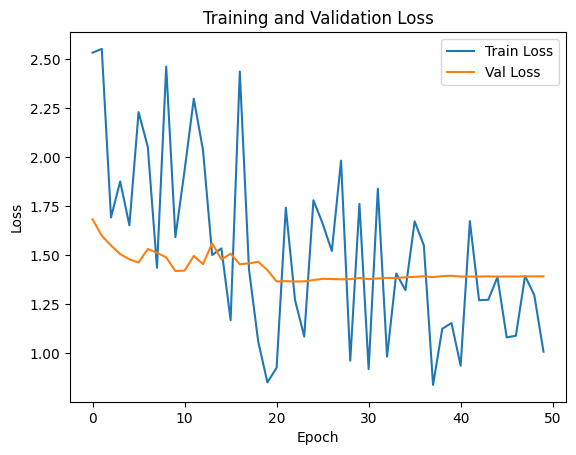

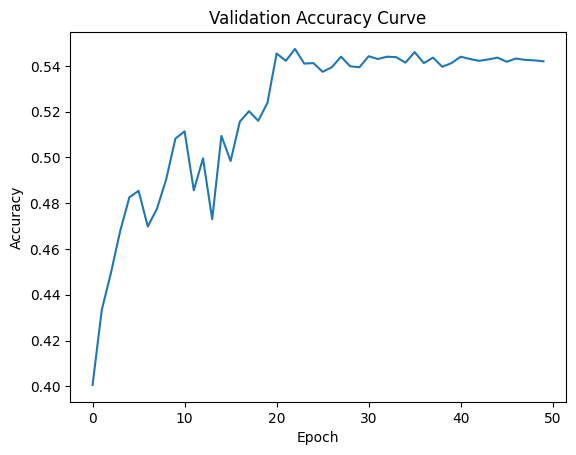

In [70]:
import matplotlib.pyplot as plt

plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Val Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.show()

plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy Curve')
plt.show()